<a href="https://colab.research.google.com/github/Mahadasim/Data_Practice/blob/master/Segmentation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#train
IMG_TRAIN_DIR =  '/content/drive/MyDrive/For Project/Segmentation/Training Data/images'
MASK_TRAIN_DIR = '/content/drive/MyDrive/For Project/Segmentation/Training Data/maska'
IMG_TEST_DIR = '/content/drive/MyDrive/For Project/Segmentation/Validation Data/images'
MASK_TEST_DIR = '/content/drive/MyDrive/For Project/Segmentation/Validation Data/masks'

In [ ]:
import os
from tqdm import tqdm
import cv2
import numpy as np

img_train = []
img_test = []
mask_train = []
mask_test = []

def load_train_data(DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256,256))
        img = img/255
        img_train.append(np.array(img))

load_train_data(IMG_TRAIN_DIR)

def load_test_data(DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256,256))
        img = img/255
        img_test.append(np.array(img))

load_test_data(IMG_TEST_DIR)

def load_train_mask(DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256,256))
        img = img/255
        mask_train.append(np.array(img))

load_train_mask(MASK_TRAIN_DIR)

def load_test_mask(DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256,256))
        img = img/255
        mask_test.append(np.array(img))

load_test_mask(MASK_TEST_DIR)

100%|██████████| 76/76 [00:03<00:00, 25.18it/s]


In [ ]:
img_train = np.array(img_train)
mask_train = np.array(mask_train)

img_test = np.array(img_test)
mask_test = np.array(mask_test)

In [ ]:
print(np.shape(img_train))
print(np.shape(mask_train))
print(np.shape(img_test))
print(np.shape(mask_test))


(762, 256, 256, 3)
(762, 256, 256, 3)
(76, 256, 256, 3)
(76, 256, 256, 3)


In [ ]:
'''import tensorflow as tf

training_dataset = tf.data.Dataset.from_tensor_slices((img_train,mask_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((img_test,mask_test))
'''

In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 100
train_batches = training_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = validation_dataset.take(3000).batch(BATCH_SIZE)
test_batches = validation_dataset.skip(3000).take(669).batch(BATCH_SIZE)


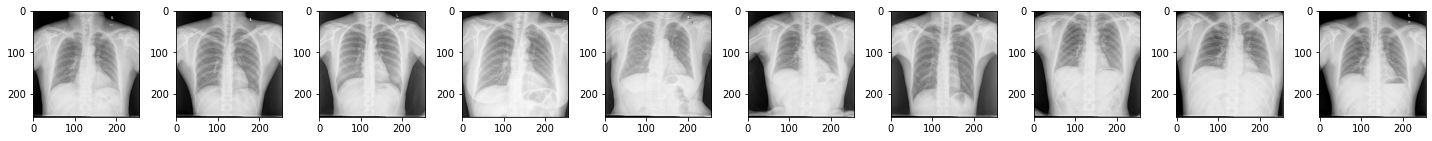

In [ ]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,10)
fig.set_size_inches(20,20)
l=0
for i in range(10):
      ax[i].imshow(img_train[i])
                

plt.tight_layout()


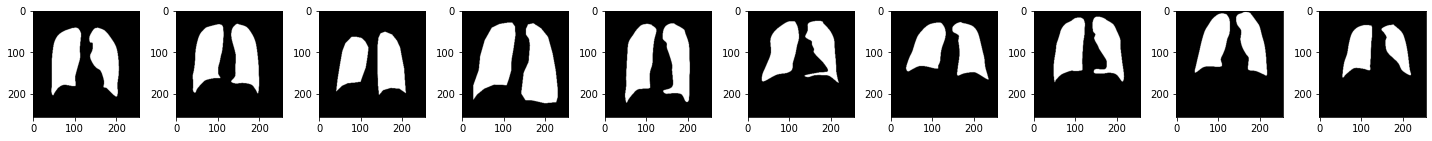

In [ ]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,10)
fig.set_size_inches(20,20)
l=0
for i in range(10):
  ax[i].imshow(mask_train[i])
                

plt.tight_layout()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

inputs = layers.Input(shape=((256,256,3)))
#s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x


# encoder: contracting path - downsample
# 1 - downsample
f1, p1 = downsample_block(inputs, 32)
# 2 - downsample
f2, p2 = downsample_block(p1, 64)
# 3 - downsample
f3, p3 = downsample_block(p2, 128)
# 4 - downsample
f4, p4 = downsample_block(p3, 256)
# 5 - bottleneck
bottleneck = double_conv_block(p4, 512)
# decoder: expanding path - upsample
# 6 - upsample
u6 = upsample_block(bottleneck, f4, 256)
# 7 - upsample
u7 = upsample_block(u6, f3, 128)
# 8 - upsample
u8 = upsample_block(u7, f2, 64)
# 9 - upsample
u9 = upsample_block(u8, f1, 32)
# outputs
outputs = layers.Conv2D(3, (1,1), padding="same", activation = "softmax")(u9)
# unet model with Keras Functional API
unet_model = tf.keras.Model(inputs, outputs=[outputs], name="U-Net")

unet_model.compile(optimizer='adam', loss='BinaryCrossentropy',
                  metrics=['accuracy'])

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_190 (Conv2D)            (None, 256, 256, 32  896         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_191 (Conv2D)            (None, 256, 256, 32  9248        ['conv2d_190[0][0]']             
                                )                                                             

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = tf.keras.callbacks.ModelCheckpoint("segmentation.h5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='min')

#run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
#my_model_history = unet_model.fit(x=img_train, y=mask_train,
#                             batch_size = 5 ,epochs = 25,
#                             validation_data = (img_test, mask_test),
#                             shuffle = True,
#                             validation_steps = 5,
#                             validation_batch_size = 5,
#                             callbacks=[early,checkpoint],steps_per_epoch=10)
                             
                             #callbacks=my_callbacks)
unet_model.fit(x=img_train, y=mask_train, epochs=10, callbacks=[early,checkpoint])


Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.4570
Epoch 1: accuracy improved from -inf to 0.45701, saving model to segmentation.h5
24/24 [==============================] - 9s 375ms/step - loss: 0.2733 - accuracy: 0.4570
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.3979
Epoch 2: accuracy did not improve from 0.45701
24/24 [==============================] - 9s 361ms/step - loss: 0.2705 - accuracy: 0.3979
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.4054
Epoch 3: accuracy did not improve from 0.45701
24/24 [==============================] - 9s 360ms/step - loss: 0.2628 - accuracy: 0.4054
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.2625 - accuracy: 0.3757
Epoch 4: accuracy did not improve from 0.45701
24/24 [==============================] - 9s 361ms/step - loss: 0.2625 - accuracy: 0.3757
Epoch 5/10
24/24 [============================

In [ ]:
unet_model.fit(x=img_train, y=mask_train, epochs=10, # one forward/backward pass of training dataages comprising of one epoch
                    validation_data=validation_batches,callbacks=[early,checkpoint], shuffle = True,
                             validation_steps = 5,
                             validation_batch_size = 5, steps_per_epoch=10
)

In [ ]:
import ipyplot
from sklearn.metrics import f1_score

my_predictions = unet_model.predict(img_test)

print(np.shape(my_predictions))

my_predictions = my_predictions[-1]

print(my_predictions.shape)


my_predictions = np.asarray(my_predictions*255).astype(np.uint8)
print(my_predictions.shape)


for i in range(len(my_predictions)):
  my_predictions[i,...] = cv2.threshold(my_predictions[i,...], 0, 1, cv2.THRESH_OTSU)[1]



ground_truths_masks = np.asarray(mask_test, dtype=np.uint8)
my_predictions = np.asarray(my_predictions, dtype=np.uint8)

print(np.shape(ground_truths_masks), np.shape(my_predictions))

#ipyplot.plot_images(mask_test*255, max_images=10, img_width=150)
#ipyplot.plot_images(my_predictions*255, max_images=10, img_width=150)

my_predictions = my_predictions.reshape(my_predictions.shape[0] * my_predictions.shape[1] * my_predictions.shape[2],1)
#ground_truths_masks = ground_truths_masks.reshape(ground_truths_masks.shape[0] * ground_truths_masks.shape[1]
#                                                  * ground_truths_masks.shape[2],1)
validation_accuracy = f1_score(ground_truths_masks, my_predictions, average='binary')

print('F1 score: ', validation_accuracy)



[[[[111.11004639  79.21846771  64.6714859 ]
   [ 89.6576004  123.99119568  41.35121155]
   [134.04763794  62.51857758  58.43377304]
   ...
   [ 97.22077942 100.52648926  57.25273514]
   [113.35682678  83.26792908  58.37522125]
   [ 42.86272049 106.76135254 105.37593079]]

  [[119.47940826  51.70065308  83.81993866]
   [ 82.57791901 144.95504761  27.46703911]
   [ 40.99121857  77.73478699 136.27400208]
   ...
   [ 93.64330292 119.00273132  42.35398483]
   [ 40.36317825 143.81547546  70.82134247]
   [ 39.48729706 169.50514221  46.00756454]]

  [[122.63782501  93.91833496  38.44385529]
   [ 79.72440338  88.51059723  86.76499939]
   [206.32049561  18.55114365  30.12836838]
   ...
   [ 95.37129974  42.06267929 117.56600952]
   [162.02105713  36.49367905  56.48525238]
   [ 26.48818779 130.53672791  97.97509003]]

  ...

  [[ 87.73834229  33.92502975 133.33662415]
   [ 47.45036697 169.41691589  38.13271332]
   [153.32342529  65.77563477  35.90093994]
   ...
   [ 83.02973938  77.88846588  94.0


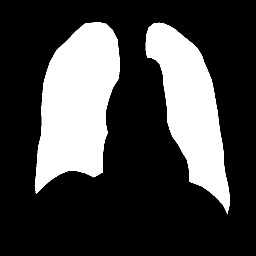
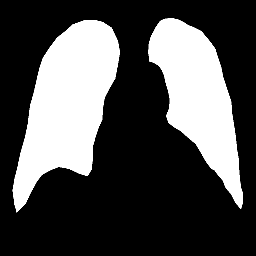
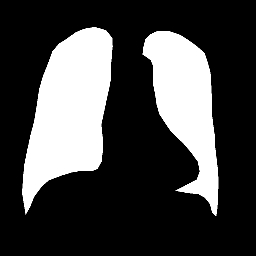
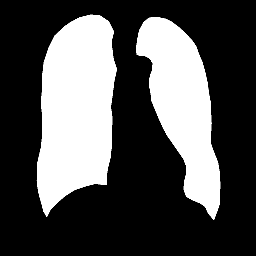
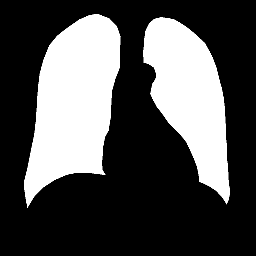
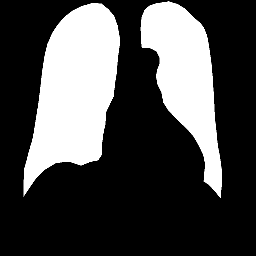
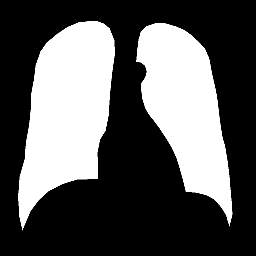
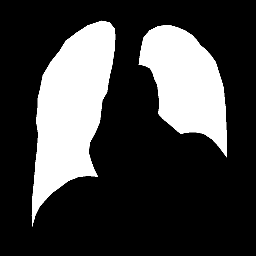
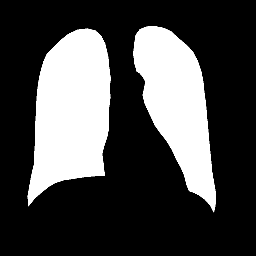
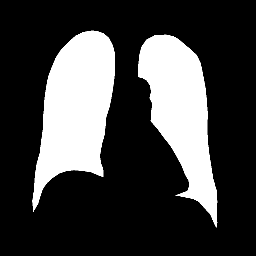


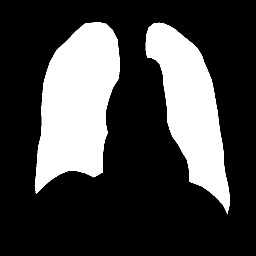
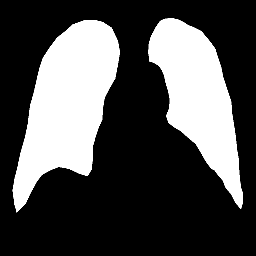
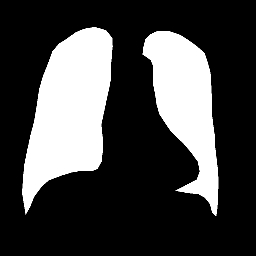
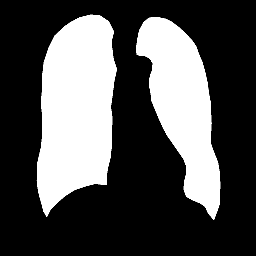
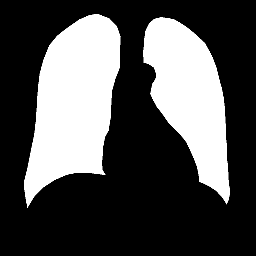
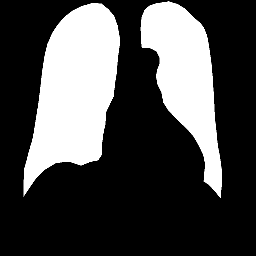
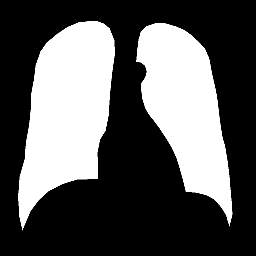
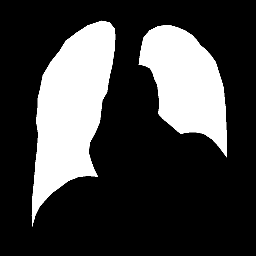
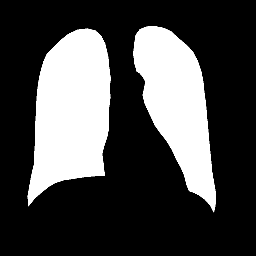
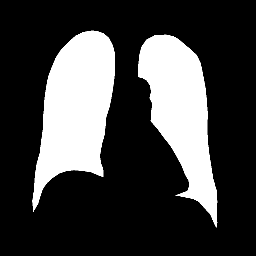


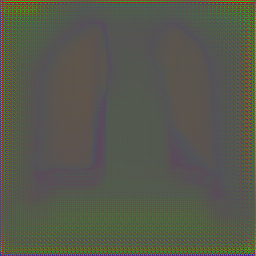
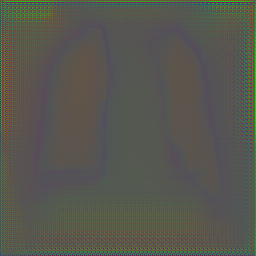
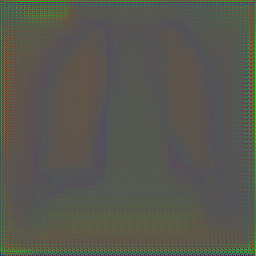
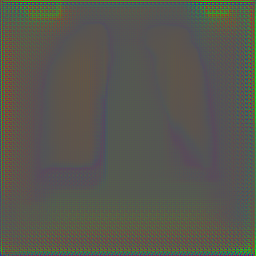
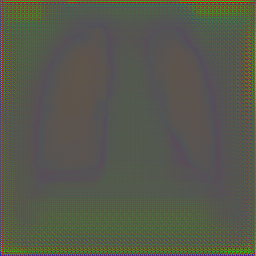
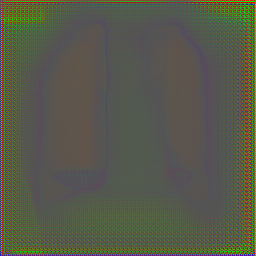
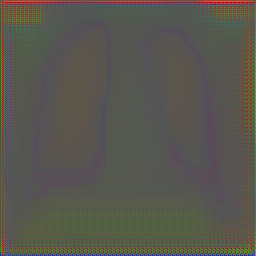
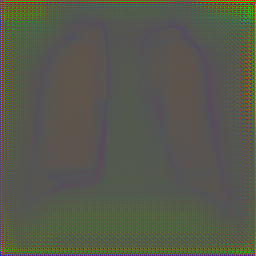
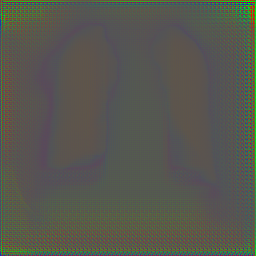
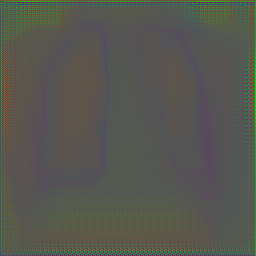


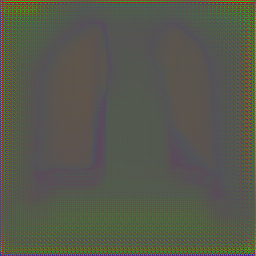
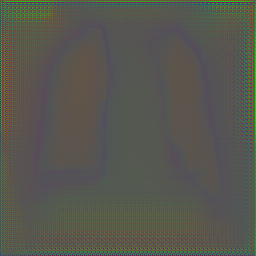
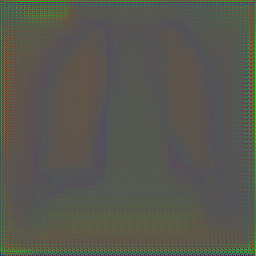
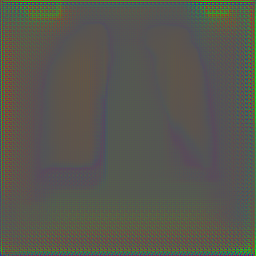
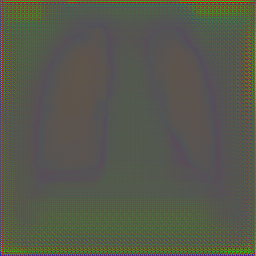
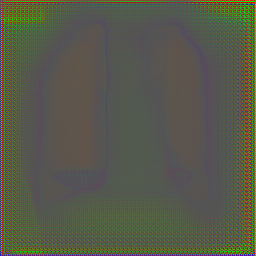
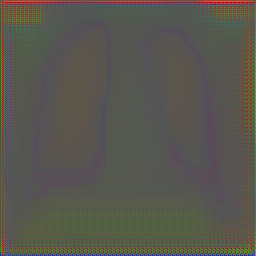
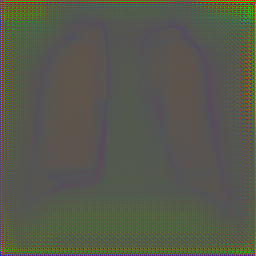
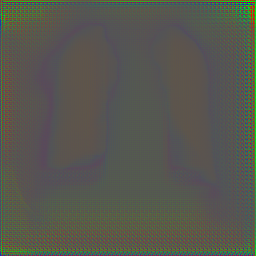
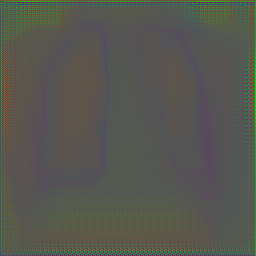

In [ ]:
from keras import backend as K
import ipyplot
from tensorflow import keras
from google.colab.patches import cv2_imshow

def dice_coefficient(y_true, y_pred, smooth=1):
  
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
  
  return K.mean((2 * intersection + smooth) / (union + smooth), axis=0)

unet_model = keras.models.load_model('segmentation.h5')

my_predictions = unet_model.predict(img_test)

y_pred = np.asarray(my_predictions*255)
#y_pred = tf.keras.layers.Lambda(lambda x: x*255)(y_pred)
y_pred = y_pred.astype(float)
y_true = mask_test
#new_pred = y_pred[-1]
#cv2_imshow(new_pred)
print(y_pred)
print(y_true.shape)

y_pred = y_pred.reshape(-1, 256, 256, 3)
y_true = y_true.reshape(-1, 256, 256, 3)

print(y_pred.shape)
print(y_true.shape)

dice_score = dice_coefficient(y_true, y_pred)

print("Dice Similarity: {}".format(dice_score))

ipyplot.plot_images(y_true, max_images=10, img_width=150)
ipyplot.plot_images(y_pred, max_images=10, img_width=150)
